# Spherical Mean Technique

The recently proposed Spherical Mean Technique (SMT) model *(Kaden et al. 2015)* is a spherical convolution-based technique, which instead of a model to multi-shell DWIs, fits the *spherical mean* of the model to the *spherical mean* of the signal per shell. 

SMT observes that if the FOD is a probability density (i.e. integrated to unity) then spherical mean of the signal and the convolution kernel must be the same

\begin{equation}
\int_{\mathbb{S}^2}E_b(\textbf{g})d\textbf{g}=\int_{\mathbb{S}^2}(\operatorname{FOD}\,*_{\mathbb{S}^2}\,K)_b(\textbf{g})d\textbf{g}=\int_{\mathbb{S}^2}K_b(\textbf{g})d\textbf{g}=\epsilon_K(b,\lambda_\perp,\lambda_\parallel).
\end{equation}

The estimation of the multi-compartment kernel using SMT enables the characterization of per-axon micro-environments, as the effects of axon dispersion and crossings are only contained in the FOD.

Advantages:
- Insensitive to axon dispersion and crossings.

Limitations:
- Only accounts for average of tissue properties in crossing configurations, which potentially each have different properties.

# Using Dmipy to set up the SMT Model

To set up the SMT model we start by calling the regular zeppelin model.

In [1]:
from dmipy.signal_models import gaussian_models
zeppelin = gaussian_models.G2Zeppelin()

To initialize a spherical mean model, instead of calling the MultiCompartmentModel, we call MultiCompartmentSphericalMeanModel.

In [2]:
from dmipy.core import modeling_framework
smt_mod = modeling_framework.MultiCompartmentSphericalMeanModel(
    models=[zeppelin])

Notice how the zeppelin's spherical mean representation has no orientation parameter 'mu'.

In [3]:
smt_mod.parameter_names

['G2Zeppelin_1_lambda_perp', 'G2Zeppelin_1_lambda_par']

The only constraint on the Zeppelin model is that $\lambda_\parallel\geq\lambda_\perp$. We can impose this parameter constraint using the model.set_fractional_parameter() function.

In [4]:
smt_mod.set_fractional_parameter('G2Zeppelin_1_lambda_perp', 'G2Zeppelin_1_lambda_par')
smt_mod.parameter_names

['G2Zeppelin_1_lambda_par', 'G2Zeppelin_1_lambda_perp_fraction']

The lambda_perp parameter has now been replaced with lambda_perp_fraction.  
In essence, what this function did is replace the original parameter with a different optimization parameter that operates as a fraction $f$ of $\lambda_{\parallel}$, such that $\lambda_{\perp}=f \times \lambda_{\parallel}$, where $1\geq f \geq 0$. Internally, the $\lambda_{\perp}$ parameter will now always respect the relative "smaller than" constraint to $\lambda_{\parallel}$, and the true value of $\lambda_{\perp}$ can be recovered after fitting the model.

## Fitting SMT to Human Connectome Project data

In [5]:
from dmipy.data import saved_data
scheme_hcp, data_hcp = saved_data.wu_minn_hcp_coronal_slice()

This data slice originates from Subject 100307 of the Human Connectome Project, WU-Minn Consortium (Principal Investigators: David Van Essen and Kamil Ugurbil; 1U54MH091657) funded by the 16 NIH Institutes and Centers that support the NIH Blueprint for Neuroscience Research; and by the McDonnell Center for Systems Neuroscience at Washington University.


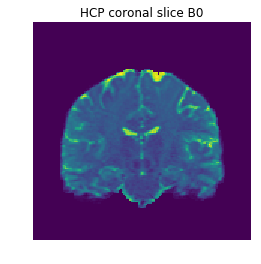

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(data_hcp[:, 0, :, 0].T, origin=True)
plt.axis('off')
plt.title('HCP coronal slice B0');

In [7]:
smt_fit_hcp = smt_mod.fit(scheme_hcp, data_hcp, Ns=30, mask=data_hcp[..., 0]>0)

Using parallel processing with 8 workers.
Setup brute2fine optimizer in 1.57689380646 seconds
Fitting of 8181 voxels complete in 30.740208149 seconds.
Average of 0.00375751230277 seconds per voxel.


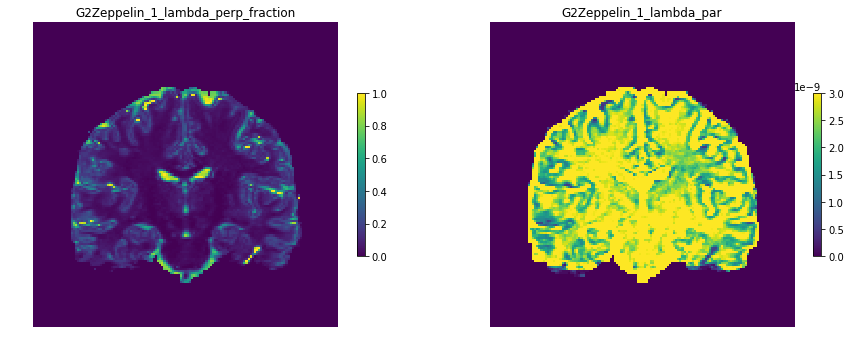

In [8]:
fitted_parameters = smt_fit_hcp.fitted_parameters

fig, axs = plt.subplots(1, len(fitted_parameters), figsize=[15, 15])
axs = axs.ravel()

for i, (name, values) in enumerate(fitted_parameters.items()):
    cf = axs[i].imshow(values.squeeze().T, origin=True)
    axs[i].set_title(name)
    axs[i].set_axis_off()
    fig.colorbar(cf, ax=axs[i], shrink=0.2)

## Tissue Segmentation based on Clustering of $\lambda_\perp$ and $\lambda_\parallel$

In their Figure 8, *(Kaden et al. 2015)* showed that the estimated $\lambda_\perp$ and $\lambda_\parallel$ in SMT are characteristic of the tissue type. Below we show that indeed it is possible make a tissue segmentation based on these parameters using simple K-Mean Clustering

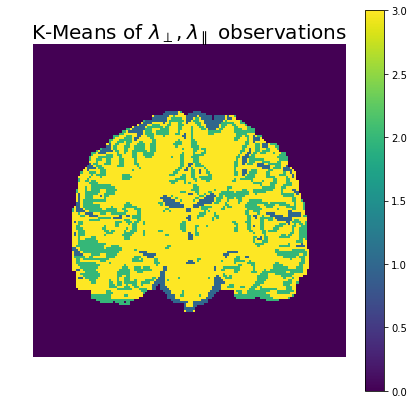

In [25]:
mask = data_hcp[..., 0]>0
lambda_perp = smt_fit_hcp.fitted_parameters_vector.prod(axis=-1)  # lambda_perp = fraction * lambda_par
lambda_par = smt_fit_hcp.fitted_parameters_vector[..., 0]

# make linear arrays of parameters in fitted voxels
lambda_perp_masked = lambda_perp[mask]
lambda_par_masked = lambda_par[mask]

# Do KNN with 3 clusters on the observations
from scipy.cluster.vq import kmeans2
import numpy as np
observations = np.c_[lambda_perp_masked, lambda_par_masked]
Nclusters = 3
centroids, classifications = kmeans2(data=observations,
                                     k=Nclusters,
                                     iter=200)

# construct segmentation image
cluster_image = np.zeros_like(lambda_par)
cluster_image[mask] = classifications + 1  # add one to differ from background

plt.figure(figsize=[7, 7])
plt.imshow(cluster_image.squeeze().T, origin=True)
plt.colorbar()
plt.axis('off');
plt.title('K-Means of $\lambda_\perp,\lambda_\parallel$ observations', fontsize=20);

The image shows that with this simple approach it is indeed possible to roughly segment the tissue into 3 types: blue for CSF, green for gray matter and yellow for white matter. However, it is also clear that this KNN approach can clearly be improved upon, as *(Kaden et al. 2015)*'s results much more cleanly delineate the different tissue types, in addition to also segmentating partial volume contaminated areas.

## Estimating Error Metrics: MSE and $R^2$

It is also possible to calculate the Mean Squared Error (MSE) and the $R^2$ coefficient of determination.  
In MSE, the lower the better, while $R^2$ ranges between 0 and 1, with 1 being a perfect model fit.

/user/rfick/home/anaconda2/lib/python2.7/site-packages/dmipy-0.1.dev0-py2.7.egg/dmipy/core/fitted_modeling_framework.py:315: RuntimeWarning: invalid value encountered in divide


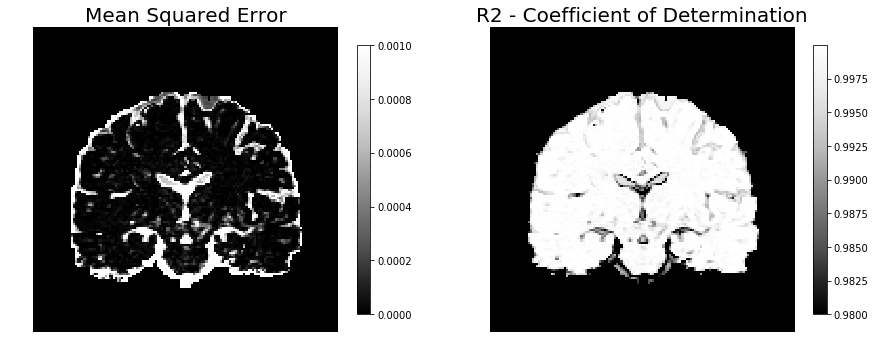

In [26]:
mse = smt_fit_hcp.mean_squared_error(data_hcp)
R2 = smt_fit_hcp.R2_coefficient_of_determination(data_hcp)

fig, axs = plt.subplots(1, 2, figsize=[15, 15])
cf = axs[0].imshow(mse.squeeze().T, origin=True, vmax=1e-3, cmap='Greys_r')
fig.colorbar(cf, ax=axs[0], shrink=0.33)
axs[0].set_title('Mean Squared Error', fontsize=20)
axs[0].set_axis_off()
cf = axs[1].imshow(R2.squeeze().T, origin=True, vmin=.98, cmap='Greys_r')
fig.colorbar(cf, ax=axs[1], shrink=0.33)
axs[1].set_title('R2 - Coefficient of Determination', fontsize=20)
axs[1].set_axis_off();

The MSE shows that the fitting error is overall very low, with higher errors in the CSF and the skull. The $R^2$ agree with the MSE results, having values very close to 1 overall, with lower values in the CSF and skull.

## References
- Kaden, Enrico, et al. "Multi-compartment microscopic diffusion imaging." NeuroImage 139 (2016): 346-359.